In [1]:
import torch
import matplotlib.pyplot as plt
from src.models import Model

DATA_FOLDER = 'data/'

/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training model: 100%|██████████| 100000/100000 [00:34<00:00, 2918.50 epoch/s]


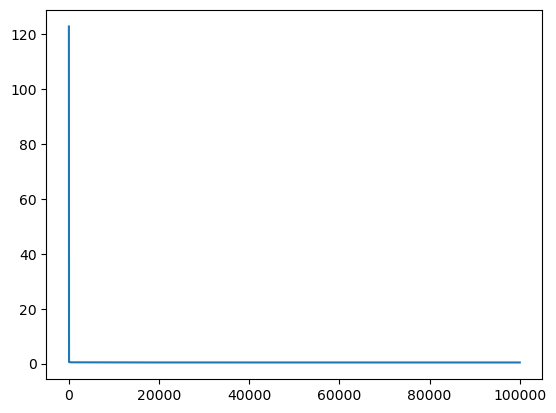

In [9]:
model = Model(nb_lags=6, lr=1e-2)

######################### Load training data: #########################
train_input, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
train_input, train_target = train_input.to(model.device), train_target.to(model.device)

######################### Load validation data: #########################
val_input, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
val_input, val_target = val_input.to(model.device), val_target.to(model.device)

# Standardize:
mean = train_target.mean().item()
std = train_target.std().item()
min_ = train_target.min()
max_ = train_target.max()

train_input = (train_input-mean)/std
# train_target = (train_target-mean)/std
val_input = (val_input-mean)/std
# val_target = (val_target-mean)/std

#train_input = (train_input-min_)/(max_-min_)
#train_target = (train_target-min_)/(max_-min_)
#val_input = (val_input-min_)/(max_-min_)
#val_target = (val_target-min_)/(max_-min_)


######################### Training: #########################
train = True
if train:
    losses = model.train(train_input, train_target, num_epochs=100000, mini_batch_size=100)
    torch.save(model, 'models/bestmodel.pth')

######################### Validation: #########################
model = torch.load('models/bestmodel.pth')
model.test(val_input, val_target)

######################### Plot training loss: #########################
plt.plot(model.train_losses)
plt.show()

In [10]:
output = model(val_input)
positive_forecast = output > 0

rate = output.sign().eq(val_target.sign()).sum() / val_target.size(0)
hit_rate = output[positive_forecast].sign().eq(val_target[positive_forecast].sign()).sum() /  positive_forecast.sum()
print(rate)
print(hit_rate)

tensor(0.5699)
tensor(0.5094)


In [11]:
output = model(train_input)
positive_forecast = output > 0

rate = output.sign().eq(train_target.sign()).sum() / train_target.size(0)
hit_rate = output[positive_forecast].sign().eq(train_target[positive_forecast].sign()).sum() / positive_forecast.sum()
print(rate)
print(hit_rate)

tensor(0.6068)
tensor(0.6420)


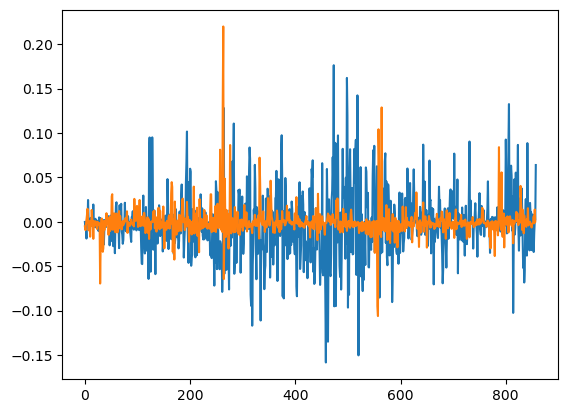

In [12]:
plt.plot(val_target.to('cpu'))
plt.plot(output.to('cpu').detach())
plt.show()